[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/openvinotoolkit/openvino_tensorflow/blob/master/docs/cloud_instructions/Colab_OpenVINO_TensorFlow_object_detection_example.ipynb)

## INSTALL OpenVINO™ integration with TensorFlow


In [7]:
# Upload the required wheel files, models and images in a google drive folder
# Uncomment and run the below command to copy them in your current workspace
#!cp /content/drive/MyDrive/TF-OV/working_dir_files/* . 

!pip -q install --upgrade pip
!pip -q install pillow

In [8]:
!ldd --version

ldd (Ubuntu GLIBC 2.27-3ubuntu1.2) 2.27
Copyright (C) 2018 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.
Written by Roland McGrath and Ulrich Drepper.


# Lets get the model

In [9]:
#steps to get yolov3_darknet
!git clone --quiet https://github.com/openvinotoolkit/openvino_tensorflow
%cd openvino_tensorflow
!git submodule init
!git submodule update --recursive
%cd ..

!apt install -qq virtualenv python3-venv
!cd openvino_tensorflow/examples/ && sed -i 's@python3 -m venv env@ virtualenv --python="/usr/bin/python3" env@g' convert_yolov3.sh && \
 sed -i 's@pip install pillow@pip install pillow numpy==1.19.5@g' convert_yolov3.sh && bash convert_yolov3.sh &>/dev/null

fatal: destination path 'openvino_tensorflow' already exists and is not an empty directory.
/content/openvino_tensorflow
/content
virtualenv is already the newest version (15.1.0+ds-1.1).
python3-venv is already the newest version (3.6.7-1~18.04).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 40 not upgraded.


In [10]:
# Install stock TensorFlow
!pip -q install tensorflow==2.4.1 

# Install OpenVINO™ integration with TensorFlow
!pip -q install openvino-tensorflow

!pip -q install openvino_tensorflow

# Now lets infer

In [11]:
from __future__ import absolute_import, division, print_function, unicode_literals
from tensorflow.keras import backend as K
from IPython.display import HTML

import argparse
import os
import numpy as np
import tensorflow as tf
import openvino_tensorflow as ovtf
import time
from PIL import Image, ImageFont, ImageDraw
import cv2
import openvino_tensorflow
import matplotlib.pyplot as plt


In [12]:
def load_graph(model_file):
    graph = tf.Graph()
    graph_def = tf.compat.v1.GraphDef()

    with open(model_file, "rb") as f:
        graph_def.ParseFromString(f.read())
    with graph.as_default():
        tf.import_graph_def(graph_def)

    return graph

In [13]:
def letter_box_image(image_path, input_height, input_width,
                     fill_value) -> np.ndarray:
    image = Image.open(image_path)
    height_ratio = float(input_height) / image.size[1]
    width_ratio = float(input_width) / image.size[0]
    fit_ratio = min(width_ratio, height_ratio)
    fit_height = int(image.size[1] * fit_ratio)
    fit_width = int(image.size[0] * fit_ratio)
    fit_image = np.asarray(
        image.resize((fit_width, fit_height), resample=Image.BILINEAR))

    fill_value = np.full(fit_image.shape[2], fill_value, fit_image.dtype)
    to_return = np.tile(fill_value, (input_height, input_width, 1))
    pad_top = int(0.5 * (input_height - fit_height))
    pad_left = int(0.5 * (input_width - fit_width))
    to_return[pad_top:pad_top + fit_height, pad_left:pad_left +
              fit_width] = fit_image

    return to_return, image

In [14]:
def load_coco_names(file_name):
    names = {}
    with open(file_name) as f:
        for id, name in enumerate(f):
            names[id] = name
    return names

In [15]:
def letter_box_pos_to_original_pos(letter_pos, current_size,
                                   ori_image_size) -> np.ndarray:
    letter_pos = np.asarray(letter_pos, dtype=np.float)
    current_size = np.asarray(current_size, dtype=np.float)
    ori_image_size = np.asarray(ori_image_size, dtype=np.float)
    final_ratio = min(current_size[0] / ori_image_size[0],
                      current_size[1] / ori_image_size[1])
    pad = 0.5 * (current_size - final_ratio * ori_image_size)
    pad = pad.astype(np.int32)
    to_return_pos = (letter_pos - pad) / final_ratio
    return to_return_pos

In [16]:
def convert_to_original_size(box, size, original_size, is_letter_box_image):
    if is_letter_box_image:
        box = box.reshape(2, 2)
        box[0, :] = letter_box_pos_to_original_pos(box[0, :], size,
                                                   original_size)
        box[1, :] = letter_box_pos_to_original_pos(box[1, :], size,
                                                   original_size)
    else:
        ratio = original_size / size
        box = box.reshape(2, 2) * ratio
    return list(box.reshape(-1))

In [17]:
def draw_boxes(boxes, img, cls_names, detection_size, is_letter_box_image):
    draw = ImageDraw.Draw(img)
    for cls, bboxs in boxes.items():
        color = (256, 256, 256)
        for box, score in bboxs:
            box = convert_to_original_size(box, np.array(detection_size),
                                           np.array(img.size),
                                           is_letter_box_image)
            draw.rectangle(box, outline=color)
            draw.text(
                box[:2],
                '{} {:.2f}%'.format(cls_names[cls], score * 100),
                fill=color)

In [18]:
def iou(box1, box2):
    b1_x0, b1_y0, b1_x1, b1_y1 = box1
    b2_x0, b2_y0, b2_x1, b2_y1 = box2

    int_x0 = max(b1_x0, b2_x0)
    int_y0 = max(b1_y0, b2_y0)
    int_x1 = min(b1_x1, b2_x1)
    int_y1 = min(b1_y1, b2_y1)

    int_area = (int_x1 - int_x0) * (int_y1 - int_y0)

    b1_area = (b1_x1 - b1_x0) * (b1_y1 - b1_y0)
    b2_area = (b2_x1 - b2_x0) * (b2_y1 - b2_y0)

    iou = int_area / (b1_area + b2_area - int_area + 1e-05)

    return iou

In [19]:
def non_max_suppression(predictions_with_boxes,
                        confidence_threshold,
                        iou_threshold=0.4):
    conf_mask = np.expand_dims(
        (predictions_with_boxes[:, :, 4] > confidence_threshold), -1)
    predictions = predictions_with_boxes * conf_mask

    result = {}
    for i, image_pred in enumerate(predictions):
        shape = image_pred.shape
        non_zero_idxs = np.nonzero(image_pred)
        image_pred = image_pred[non_zero_idxs]
        image_pred = image_pred.reshape(-1, shape[-1])

        bbox_attrs = image_pred[:, :5]
        classes = image_pred[:, 5:]
        classes = np.argmax(classes, axis=-1)

        unique_classes = list(set(classes.reshape(-1)))

        for cls in unique_classes:
            cls_mask = classes == cls
            cls_boxes = bbox_attrs[np.nonzero(cls_mask)]
            cls_boxes = cls_boxes[cls_boxes[:, -1].argsort()[::-1]]
            cls_scores = cls_boxes[:, -1]
            cls_boxes = cls_boxes[:, :-1]

            while len(cls_boxes) > 0:
                box = cls_boxes[0]
                score = cls_scores[0]
                if not cls in result:
                    result[cls] = []
                result[cls].append((box, score))
                cls_boxes = cls_boxes[1:]
                # iou threshold check for overlapping boxes
                ious = np.array([iou(box, x) for x in cls_boxes])
                iou_mask = ious < iou_threshold
                cls_boxes = cls_boxes[np.nonzero(iou_mask)]
                cls_scores = cls_scores[np.nonzero(iou_mask)]
    return result

In [20]:
def infer_openvino_tensorflow(model_file, input_layer, output_layer, image_file , input_height, input_width, input_mean, input_std, label_file):
    print("CREATE MODEL - BEGIN")

    # Load graph and process input image
    graph = load_graph(model_file)
    print("CREATE MODEL - END")

    img_resized, img = letter_box_image(image_file, input_height, input_width,
                                       128)
    img_resized = img_resized.astype(np.float32)
    if label_file:
        classes = load_coco_names(label_file)
    input_name = "import/" + input_layer
    output_name = "import/" + output_layer
    input_operation = graph.get_operation_by_name(input_name)
    output_operation = graph.get_operation_by_name(output_name)

    # update config params for openvino tensorflow addon
    config = tf.compat.v1.ConfigProto()
    config_ngraph_enabled = ovtf.update_config(config)

    print("PREDICTION - BEGIN")
    
    with tf.compat.v1.Session(
            graph=graph, config=config_ngraph_enabled) as sess:
        # Warmup
        detected_boxes = sess.run(output_operation.outputs[0],
                                  {input_operation.outputs[0]: [img_resized]})
        # Run
        import time
        start = time.time()
        detected_boxes = sess.run(output_operation.outputs[0],
                                  {input_operation.outputs[0]: [img_resized]})
        elapsed = time.time() - start
        print('Inference time in ms: %f' % (elapsed * 1000))
    print("PREDICTION - END")  
       
    # apply non max suppresion, draw boxes and save updated image
    filtered_boxes = non_max_suppression(detected_boxes, conf_threshold,
                                        iou_threshold)
    draw_boxes(filtered_boxes, img, classes, (input_width, input_height), True)
    if output_dir:
        img.save(os.path.join(output_dir, "detections.jpg"))
    else:
        img.save("detections.jpg")
    plt.imshow(img)   

/content/openvino_tensorflow/examples
Available Backends:
CPU
OpenVINO TensorFlow is enabled
CREATE MODEL - BEGIN
CREATE MODEL - END
PREDICTION - BEGIN
Inference time in ms: 1092.716455
PREDICTION - END


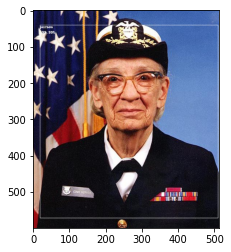

In [21]:
   %cd openvino_tensorflow/examples/
   image_file = "data/grace_hopper.jpg"
   model_file = "data/yolo_v3_darknet.pb"
   label_file = "data/coco.names"
   input_height = 416
   input_width = 416
   input_mean = 0
   input_std = 255
   input_layer = "inputs"
   output_layer = "output_boxes"
   backend_name = "CPU"
   output_dir = "."
   conf_threshold = 0.6
   iou_threshold = 0.5
   
   #Print list of available backends
   print('Available Backends:')
   backends_list = ovtf.list_backends()
   for backend in backends_list:
       print(backend)
   ovtf.set_backend(backend_name)

   print("OpenVINO TensorFlow is enabled")
   infer_openvino_tensorflow(model_file, input_layer, output_layer, image_file, input_height, input_width, input_mean, input_std, label_file )
   



OpenVINO TensorFlow is disabled
CREATE MODEL - BEGIN
CREATE MODEL - END
PREDICTION - BEGIN
Inference time in ms: 1254.867077
PREDICTION - END


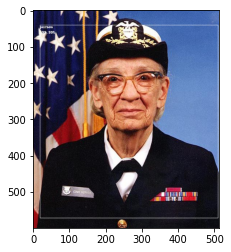

In [22]:
#Disable
ovtf.disable()
print("")
print("")
print("OpenVINO TensorFlow is disabled")
infer_openvino_tensorflow(model_file, input_layer, output_layer, image_file, input_height, input_width, input_mean, input_std, label_file )
ovtf.enable()
